# Cassandra - LJ example

environment setup

* switched to conda mosdef cassandra

`conda create -n cassandra -y -c conda-forge -c mosdef -c omnia 'python=3.7' mbuild foyer openbabel fresnel py3dmol 'nodejs>=10' jupyterlab mosdef_cassandra matplotlib` 

`conda activate cassandra`

### Units

I've been confused about units, so here are my notes to keep things together. I think mosdef cassandra should handle the energy unit conversion, but I can't find the code where this is done.

#### Cassandra
- length: Å
- energy $\frac{\epsilon}{k_{B}}$: K

#### Foyer
- length: nm
- energy: $\frac{kcal}{mol}$

#### Parmed
- length: Å
- energy: $\frac{kcal}{mol}$

In [171]:
import mosdef_cassandra as mc
import foyer
import mbuild as mb
import numpy as np
#import unyt as u
from numpy.linalg import norm
import matplotlib.pyplot as plt

import ex_render_cassandra as erc

plt.rcParams.update({"font.size": 22, "figure.figsize": (10,6)})

If the cell below fails, you need to add Cassandra to your path

```
export PATH=/Users/$(whoami)/Projects/Cassandra_V1.2/bin:${PATH}
```

In [5]:
mc.utils.detect_cassandra_binaries();

Using the following executables for Cassandra:
Python: /Users/jenny/miniconda3/envs/cassandra/bin/python
library_setup: /Users/jenny/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/jenny/miniconda3/envs/cassandra/bin/cassandra.exe


In [6]:
# ff units nm kcal/mol 
# (doesn't matter except that mbuild converts things without telling us :c)
lj_ff = foyer.Forcefield()
lj_ff.loadFile("FF_xmls/LJ.xml")

/Users/jenny/miniconda3/envs/cassandra/lib/python3.7/site-packages/foyer/forcefield.py:457: UserWarning: Non-atomistic element type detected. Creating custom element for 
  'Creating custom element for {}'.format(element))


In [9]:
ljium = mb.Compound(name="C", pos=[0,0,0]) 
# using "C" as name is a hacky way to make foyer work,
# but this is LJium--not carbon
#ljium.visualize().show()

In [52]:
#typed_ljium.atoms[0].uepsilon
#typed_ljium.atoms[0].usigma

In [45]:
typed_ljium = lj_ff.apply(
    ljium, assert_bond_params=False, assert_angle_params=False, 
    assert_dihedral_params=False
) 
L = 10 # this gets multiplied in cassandra x10 (nm->A) 
# but length scale is same as FF
box = mb.Box(mins=[-L/2]*3, maxs=[L/2]*3)

/Users/jenny/miniconda3/envs/cassandra/lib/python3.7/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)


In [67]:
eps = typed_ljium.atoms[0].epsilon
print(f"epsilon: {eps:.2f}")
print("sigma: ", typed_ljium.atoms[0].sigma)
# ParmEd is in kcal/mol

kb = 0.001985875    # kcal/(mol K)
T = eps/kb

print(f"The unit temperature is {T:.0f} K")

epsilon: 0.24
sigma:  10.0
The unit temperature is 120 K


In [139]:
# remove previous runs
!rm -rf species* *.out.* *.inp mosdef*.log

In [138]:
def run_cassandra(chem_pot, temp):
    # Create box and species list
    box_list = [box]
    species_list = [typed_ljium]

    # Since we have an occupied box we need to specify
    # the number of each species present in the intial config
    mols_in_boxes = [[0]]

    system = mc.System(box_list, species_list, mols_in_boxes=mols_in_boxes)
    moves = mc.Moves("gcmc", species_list)

    custom_args = {
        "run_name": f"equil_{chem_pot:.0f}_{temp:.0f}",
        "chemical_potentials": [chem_pot],
        "rcut_min": 0.5,
        "vdw_cutoff": min(box.lengths)/2.1,
        "charge_style": "none",
        #"charge_cutoff": 14.0,
        "coord_freq": 100,
        "prop_freq": 10,
    }

    mc.run(
        system=system, 
        moves=moves, 
        run_type="equilibration", 
        run_length=10000, 
        temperature=temp, 
        **custom_args
    )
    
    # Set max translate and volume for production
    moves.max_translate = [[10.0]] # angstroms

    # Update run_name and restart_name
    custom_args["run_name"] = f"prod_{chem_pot:.0f}_{temp:.0f}"
    custom_args["restart_name"] = f"equil_{chem_pot:.0f}_{temp:.0f}"

    mc.restart(
        system=system,
        moves=moves,
        run_type="production",
        run_length=50000,
        temperature=temp,
        **custom_args,
    )

In [137]:
# If you want to check whether your run completed successfully
# This should say "Cassandra simulation complete"
#!tail -1 mosdef*.log

In [140]:
chem_pots = [i*T for i in range(0,4)] 
temp = 2*T

for chem_pot in chem_pots:
    run_cassandra(chem_pot,temp)

Using the following executables for Cassandra:
Python: /Users/jenny/miniconda3/envs/cassandra/bin/python
library_setup: /Users/jenny/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/jenny/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...


/Users/jenny/miniconda3/envs/cassandra/lib/python3.7/site-packages/mbuild/formats/cassandramcf.py:178: UserWarning: No bonds found. Cassandra will interpet this as a rigid species
  warnings.warn("No bonds found. Cassandra will interpet "


Using the following executables for Cassandra:
Python: /Users/jenny/miniconda3/envs/cassandra/bin/python
library_setup: /Users/jenny/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/jenny/miniconda3/envs/cassandra/bin/cassandra.exe
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/jenny/miniconda3/envs/cassandra/bin/python
library_setup: /Users/jenny/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/jenny/miniconda3/envs/cassandra/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/jenny/miniconda3/envs/cassandra/bin/python
library_setup: /Users/jenny/miniconda3/envs/cassandra/bin/library_setup.py
Cassandra: /Users/jenny/miniconda3/envs/cassandra/bin/cassandra.exe
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/jenny/miniconda3/envs/cassandra/bin/python
library_setup: /Users/jenny/miniconda3/envs/cassandra/b

# Adsorption Isotherm

Number vs pressure at constant T

[notes from lab meeting here](https://etherpad.boisestate.edu/p/ldrd-s20-4)

In [152]:
# prp file is where the properties live

# STEP Energy_Total Energy_Intra Energy_Inter Enthalpy Pressure Volume Nmols Mass_Density  
#     (kJ/mol)-Ext  (kJ/mol)-Ext (kJ/mol)-Ext          (bar)    (A^3)        (kg/m^3) 

#print(f"{chem_pot:.0f} {temp:.0f}")
pressures = []
nmols = []
for chem_pot in chem_pots:
    a = np.loadtxt(f"prod_{chem_pot:.0f}_{temp:.0f}.out.prp")
    pressures.append(np.mean(a[:,5]))
    nmols.append(np.mean(a[:,7]))

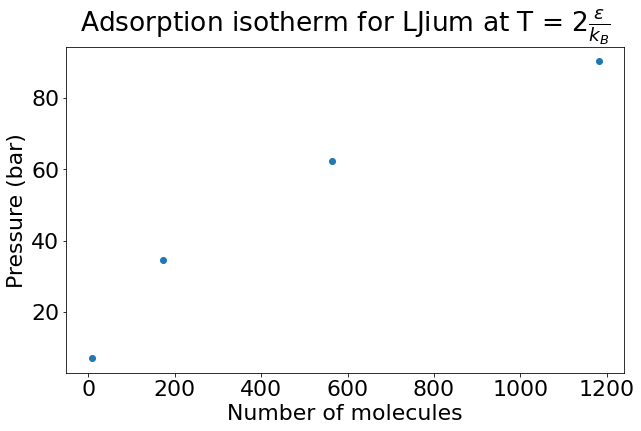

In [172]:
plt.title(r"Adsorption isotherm for LJium at T = 2$\frac{\epsilon}{k_{B}}$")
plt.scatter(pressures,nmols)
plt.ylabel("Pressure (bar)")
plt.xlabel("Number of molecules")
plt.show()

In [128]:
# These cells are for visualizing output
xyzfile = f"prod_{chem_pot:.0f}_{temp:.0f}.out.xyz"
boxfile = f"prod_{chem_pot:.0f}_{temp:.0f}.out.H"
traj = erc.make_traj(xyzfile, boxfile)
print(len(traj))

400


In [122]:
# slow!
if len(traj) > 0:
    erc.display_movie(erc.render_sphere_frame, traj, gif="lj_results/prod.gif")
else:
    print("no frames in trajectory!")

![](lj_results/prod.gif)